# Importing all libraries

In [3]:
import torch
import torchaudio
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import numpy as np
import seaborn as sns
import os
from collections import Counter
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import models
from torch import optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm  

# Classes

In [4]:
dataset_path = 'D:/Data science projects/Emotion detection/data/FER2013/train'
dataset = datasets.ImageFolder(root=dataset_path,transform=transforms.ToTensor())
print(f'No.of classes : {len(dataset.classes)}')

No.of classes : 7


In [5]:
print(f'Classes : {dataset.classes}')

Classes : ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


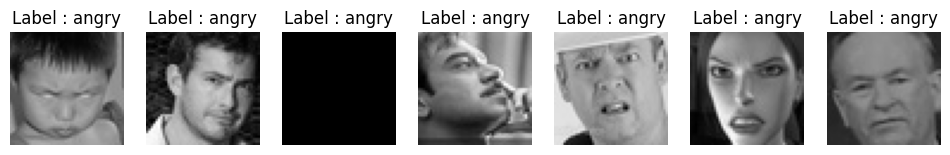

In [6]:
# Displaying sample images

def show_images(dataset,num_samples=7):
    plt.figure(figsize=(12,6))
    for i in range(num_samples):
        image, label = dataset[i]
        image = transforms.ToPILImage()(image)
        plt.subplot(1,num_samples,i+1)
        plt.imshow(image)
        plt.title(f'Label : {dataset.classes[label]}')
        plt.axis('off')
    plt.show()
show_images(dataset)

Skipping blank image at index 2


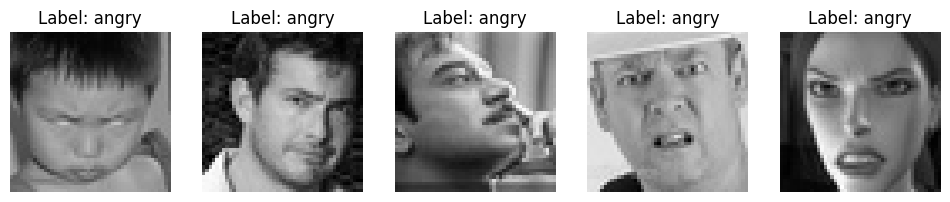

In [10]:
# Skipping the blank images 

def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(12, 6))
    shown_images = 0
    

    for i in range(len(dataset)):
        if shown_images >= num_samples:
            break
        try:
            image, label = dataset[i]
            image = transforms.ToPILImage()(image)

            if np.array(image).sum() == 0:
                print(f"Skipping blank image at index {i}")
                continue

            plt.subplot(1, num_samples, shown_images + 1)
            plt.imshow(image)
            plt.title(f"Label: {dataset.classes[label]}")
            plt.axis('off')
            shown_images += 1

        except Exception as e:
            print(f"Error loading image at index {i}: {e}")
            continue

    plt.show()

show_samples(dataset)

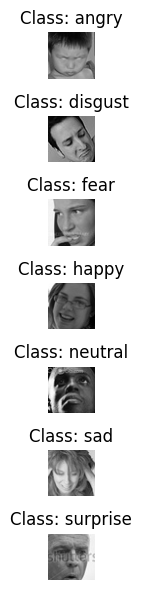

In [11]:
# display images from each class

def show_samples_per_class(dataset, num_samples_per_class=1):
    class_samples = {class_name: [] for class_name in dataset.classes}  
    
    for image, label in dataset:
        class_name = dataset.classes[label]
        if len(class_samples[class_name]) < num_samples_per_class:
            class_samples[class_name].append((image, label))
        
        if all(len(samples) >= num_samples_per_class for samples in class_samples.values()):
            break

    total_classes = len(dataset.classes)
    plt.figure(figsize=(6, 6))  

    for i, (class_name, samples) in enumerate(class_samples.items()):
        for j, (image, label) in enumerate(samples):
            image = transforms.ToPILImage()(image)
            plt.subplot(total_classes, num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(image)
            plt.title(f"Class: {class_name}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

show_samples_per_class(dataset)

In [12]:
# checking no of images available in dataset
dataset_path1 = 'D:/Data science projects/Emotion detection/data/FER2013/train'
dataset_path2 = 'D:/Data science projects/Emotion detection/data/FER2013/test'

transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor()])

dataset1 = datasets.ImageFolder(root=dataset_path1,transform=transform)
dataset2 = datasets.ImageFolder(root=dataset_path2,transform=transform)

print(f"Total images in train dataset : {len(dataset1)}")

print(f"Total images in test dataset : {len(dataset2)}")

Total images in train dataset : 28709
Total images in test dataset : 7178


In [13]:
total = len(dataset1) + len(dataset2)

print(f"(Total no. of images : {total})")

(Total no. of images : 35887)


In [14]:
loader = DataLoader(dataset1,batch_size=64,shuffle=True)
def get_dataset_stats(dataset):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)  
        images = images.view(batch_samples, images.size(1), -1) 
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count
    return mean, std

mean, std = get_dataset_stats(dataset1)

In [15]:
print(f"Mean: {mean}, STD:{std}")

Mean: tensor([0.5077]), STD:tensor([0.2120])


# Class distribution


Class distribution before Balancing
Class Angry : 3995
Class Disgust : 436
Class Fear : 4097
Class Happy : 7215
Class Sad : 4965
Class Surprise : 4830
Class Neutral : 3171


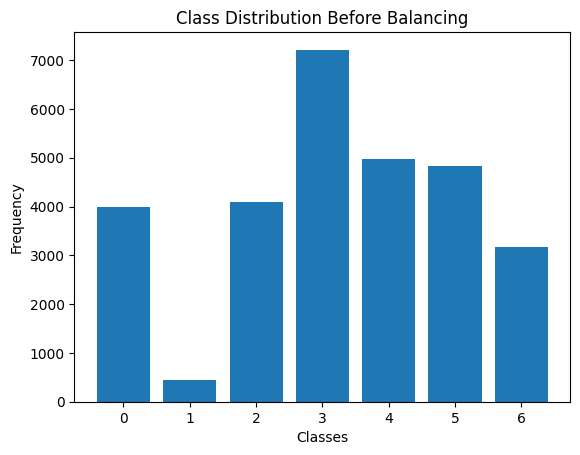

In [16]:
transform1 = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                ])

train_dataset1 = datasets.ImageFolder(root='D:/Data science projects/Emotion detection/data/FER2013/train',transform=transform1)
test_dataset1 = datasets.ImageFolder(root='D:/Data science projects/Emotion detection/data/FER2013/test',transform=transform1)


train_labels = [label for _, label in train_dataset1]
class_counts = Counter(train_labels)

class_mapping = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}


print("Class distribution before Balancing")
for class_label, count in class_counts.items():
    class_name = class_mapping[class_label]  
    print(f'Class {class_name} : {count}')

plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution Before Balancing')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

In [17]:
print(class_counts)

Counter({3: 7215, 4: 4965, 5: 4830, 2: 4097, 0: 3995, 6: 3171, 1: 436})


# Handling inbalanced data

Class distribution after Balancing:
Class Sad : 4012
Class Neutral : 4093
Class Disgust : 4138
Class Angry : 3991
Class Happy : 4134
Class Surprise : 4178
Class Fear : 4163


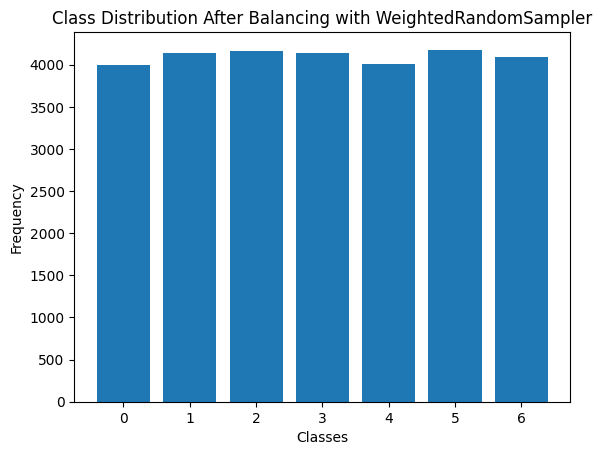

In [18]:
class_weights = 1. / np.array([class_counts[i] for i in range(len(class_counts))])
sample_weights = [class_weights[label] for _, label in train_dataset1]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader1 = DataLoader(train_dataset1, sampler=sampler, batch_size=64)

sampled_labels = []
for data, label in train_loader1:
    sampled_labels.extend(label.tolist())

balanced_class_counts = Counter(sampled_labels)

print("Class distribution after Balancing:")
for class_label, count in balanced_class_counts.items():
    class_name = class_mapping[class_label]  
    print(f'Class {class_name} : {count}')

plt.bar(balanced_class_counts.keys(), balanced_class_counts.values())
plt.title('Class Distribution After Balancing with WeightedRandomSampler')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.show()

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# ResNet18 model

In [31]:
# Define transformations
transform1 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the dataset
train_dataset1 = datasets.ImageFolder(root='D:/Data science projects/Emotion detection/data/FER2013/train', transform=transform1)
test_dataset1 = datasets.ImageFolder(root='D:/Data science projects/Emotion detection/data/FER2013/test', transform=transform1)

# Print the total number of samples
print(f"Total training samples: {len(train_dataset1)}")

# Define the number of samples you want for the subset
subset_size = 3000  # Define how many samples you want in your subset
if subset_size > len(train_dataset1):
    raise ValueError("Subset size exceeds total training samples.")

# Create a random subset of indices
np.random.seed(42)  # For reproducibility
subset_indices = np.random.choice(len(train_dataset1), size=subset_size, replace=False)

# Create a subset of the dataset
train_subset = Subset(train_dataset1, subset_indices)

# Calculate class counts and weights for WeightedRandomSampler
train_labels = [label for _, label in train_subset]
class_counts = Counter(train_labels)
class_weights = 1. / np.array([class_counts[i] for i in range(len(class_counts))])
sample_weights = [class_weights[label] for label in train_labels]

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders
train_loader1 = DataLoader(train_subset, sampler=sampler, batch_size=64)

# train_loader1 = DataLoader(subset_train_dataset,sampler=sampler, batch_size=64)
test_loader1 = DataLoader(test_dataset1,batch_size=64,shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet18(pretrained=True)
model.to(device)  

for param in model.parameters():
    param.requires_grad=False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features,7)
model.fc.to(device)

for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
num_epochs = 20

train_loss = []
test_loss = []
test_accuracy = []

for i in range(num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader1), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader1:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader1)
        if i%5 == 0:
            print(f'Epoch {i}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # # Save the model every 2 epochs
        # if (i + 1) % 2 == 0:
        #     torch.save(model.state_dict(), f"models/resnet18_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader1), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader1:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Compute loss
                _, predictions = torch.max(outputs.data, 1)  # Get predictions
                total += targets.size(0)
                correct += (predictions == targets).sum().item()
                running_test_loss += loss.item()

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader1)
    accuracy = correct / total
    if i%5 == 0:

        print(f'Epoch {i}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss.append(avg_train_loss)
    test_loss.append(avg_test_loss)
    test_accuracy.append(accuracy)


Total training samples: 28709


d:\Data science projects\Emotion detection\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Data science projects\Emotion detection\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20: 100%|██████████| 47/47 [03:31<00:00,  4.51s/batch, Loss=1.94]


Epoch 0/20 Training Loss: 1.9727


Evaluating: 100%|██████████| 113/113 [08:50<00:00,  4.70s/batch]


Epoch 0/20 Test Loss: 1.9619, Test Accuracy: 0.1697


Epoch 6/20: 100%|██████████| 47/47 [03:33<00:00,  4.53s/batch, Loss=1.64]


Epoch 5/20 Training Loss: 1.6490


Evaluating: 100%|██████████| 113/113 [07:56<00:00,  4.21s/batch]


Epoch 5/20 Test Loss: 1.6909, Test Accuracy: 0.3458


Epoch 11/20: 100%|██████████| 47/47 [03:30<00:00,  4.48s/batch, Loss=1.53]


Epoch 10/20 Training Loss: 1.5683


Evaluating: 100%|██████████| 113/113 [07:37<00:00,  4.05s/batch]


Epoch 10/20 Test Loss: 1.7541, Test Accuracy: 0.3168


Epoch 16/20: 100%|██████████| 47/47 [03:26<00:00,  4.39s/batch, Loss=1.75]


Epoch 15/20 Training Loss: 1.4907


Evaluating: 100%|██████████| 113/113 [07:21<00:00,  3.91s/batch]


Epoch 15/20 Test Loss: 1.6355, Test Accuracy: 0.3622


Evaluating: 100%|██████████| 113/113 [07:49<00:00,  4.15s/batch]


In [33]:
# Save the final model
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
torch.save(model.state_dict(), "models/resnet18.pth")

In [2]:
model = models.resnet18(pretrained=True)

model.load_state_dict(torch.load('models/resnet18.pth'))

optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
num_epochs = 25

for i in range(20,num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader1), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader1:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader1)
        print(f'Epoch {i + 1}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # # Save the model every 2 epochs
        # if (i + 1) % 2 == 0:
        #     torch.save(model.state_dict(), f"models/resnet18_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader1), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader1:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Compute loss
                _, predictions = torch.max(outputs.data, 1)  # Get predictions
                total += targets.size(0)
                correct += (predictions == targets).sum().item()
                running_test_loss += loss.item()

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader1)
    accuracy = correct / total
    print(f'Epoch {i + 1}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss.append(avg_train_loss)
    test_loss.append(avg_test_loss)
    test_accuracy.append(accuracy)


NameError: name 'models' is not defined

# GoogleNet Model

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.googlenet(pretrained=True)
model.to(device)  

for param in model.parameters():
    param.requires_grad=False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features,7)
model.fc.to(device)

for param in model.fc.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.001)
num_epochs = 15

train_loss1 = []
test_loss1 = []
test_accuracy1 = []

for i in range(num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader1), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader1:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader1)
        print(f'Epoch {i + 1}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # Save the model every 2 epochs
        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"models/googlenet_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader1), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader1:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)  # Compute loss
                _, predictions = torch.max(outputs.data, 1)  # Get predictions
                total += targets.size(0)
                correct += (predictions == targets).sum().item()
                running_test_loss += loss.item()

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader1)
    accuracy = correct / total
    print(f'Epoch {i + 1}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss1.append(avg_train_loss)
    test_loss1.append(avg_test_loss)
    test_accuracy1.append(accuracy)

# Save the final model
torch.save(model.state_dict(), "models/model_googlenet.pth")
    

Epoch 1/15: 100%|██████████| 47/47 [06:08<00:00,  7.83s/batch, Loss=1.84]


Epoch 1/15 Training Loss: 1.9135


Evaluating: 100%|██████████| 113/113 [13:26<00:00,  7.14s/batch]


Epoch 1/15 Test Loss: 1.9159, Test Accuracy: 0.1988


Epoch 2/15: 100%|██████████| 47/47 [06:07<00:00,  7.82s/batch, Loss=1.86]


Epoch 2/15 Training Loss: 1.8281


Evaluating: 100%|██████████| 113/113 [14:06<00:00,  7.49s/batch]


Epoch 2/15 Test Loss: 1.7700, Test Accuracy: 0.3270


Epoch 3/15: 100%|██████████| 47/47 [06:08<00:00,  7.84s/batch, Loss=1.81]


Epoch 3/15 Training Loss: 1.7546


Evaluating: 100%|██████████| 113/113 [9:00:27<00:00, 286.97s/batch]   


Epoch 3/15 Test Loss: 1.7852, Test Accuracy: 0.2779


Epoch 4/15: 100%|██████████| 47/47 [06:12<00:00,  7.93s/batch, Loss=1.62]


Epoch 4/15 Training Loss: 1.7118


Evaluating: 100%|██████████| 113/113 [13:39<00:00,  7.25s/batch]


Epoch 4/15 Test Loss: 1.7193, Test Accuracy: 0.3380


Epoch 5/15: 100%|██████████| 47/47 [06:09<00:00,  7.85s/batch, Loss=1.56]


Epoch 5/15 Training Loss: 1.6754


Evaluating: 100%|██████████| 113/113 [13:51<00:00,  7.36s/batch]


Epoch 5/15 Test Loss: 1.7624, Test Accuracy: 0.3023


Epoch 6/15: 100%|██████████| 47/47 [06:20<00:00,  8.10s/batch, Loss=1.62]


Epoch 6/15 Training Loss: 1.6508


Evaluating: 100%|██████████| 113/113 [13:59<00:00,  7.43s/batch]


Epoch 6/15 Test Loss: 1.7465, Test Accuracy: 0.3160


Epoch 7/15: 100%|██████████| 47/47 [05:53<00:00,  7.52s/batch, Loss=1.66]


Epoch 7/15 Training Loss: 1.6252


Evaluating: 100%|██████████| 113/113 [13:17<00:00,  7.06s/batch]


Epoch 7/15 Test Loss: 1.7099, Test Accuracy: 0.3306


Epoch 8/15: 100%|██████████| 47/47 [06:15<00:00,  7.99s/batch, Loss=1.57]


Epoch 8/15 Training Loss: 1.6176


Evaluating: 100%|██████████| 113/113 [13:23<00:00,  7.11s/batch]


Epoch 8/15 Test Loss: 1.7073, Test Accuracy: 0.3165


Epoch 9/15: 100%|██████████| 47/47 [06:11<00:00,  7.91s/batch, Loss=1.68]


Epoch 9/15 Training Loss: 1.5962


Evaluating: 100%|██████████| 113/113 [13:12<00:00,  7.01s/batch]


Epoch 9/15 Test Loss: 1.6471, Test Accuracy: 0.3543


Epoch 10/15: 100%|██████████| 47/47 [05:50<00:00,  7.46s/batch, Loss=1.57]


Epoch 10/15 Training Loss: 1.6242


Evaluating: 100%|██████████| 113/113 [23:20<00:00, 12.40s/batch]  


Epoch 10/15 Test Loss: 1.6170, Test Accuracy: 0.3865


Epoch 11/15:  32%|███▏      | 15/47 [01:55<04:06,  7.69s/batch, Loss=1.56]


KeyboardInterrupt: 

In [2]:
# Save the final model
torch.save(model.state_dict(), "models/model_googlenet.pth")


NameError: name 'model' is not defined

# CNN Model

In [4]:
transform2 = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((128,128)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                                ])

# Load the dataset
train_dataset2 = datasets.ImageFolder(root='D:/Data science projects/Emotion detection/data/FER2013/train', transform=transform2)
test_dataset2 = datasets.ImageFolder(root='D:/Data science projects/Emotion detection/data/FER2013/test', transform=transform2)

# Print the total number of samples
print(f"Total training samples: {len(train_dataset2)}")

# Define the number of samples you want for the subset
subset_size2 = 4000  # Define how many samples you want in your subset
if subset_size2 > len(train_dataset2):
    raise ValueError("Subset size exceeds total training samples.")

# Create a random subset of indices
np.random.seed(42)  # For reproducibility
subset_indices2 = np.random.choice(len(train_dataset2), size=subset_size2, replace=False)

# Create a subset of the dataset
train_subset2 = Subset(train_dataset2, subset_indices2)

# Calculate class counts and weights for WeightedRandomSampler
train_labels = [label for _, label in train_subset2]
class_counts = Counter(train_labels)
class_weights = 1. / np.array([class_counts[i] for i in range(len(class_counts))])
sample_weights = [class_weights[label] for label in train_labels]

# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders
train_loader2 = DataLoader(train_subset2, sampler=sampler, batch_size=64)
test_loader2 = DataLoader(test_dataset2,batch_size=64,shuffle=True)



Total training samples: 28709


In [5]:
class DeepEmotionCNN1(nn.Module):
    def __init__(self):
        super(DeepEmotionCNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,stride=1,padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3,stride=1,padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512*8*8,512)
        self.fc2 = nn.Linear(512,7)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1,512*8*8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DeepEmotionCNN1()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
num_epochs = 10

train_loss4 = []
test_loss4 = []
test_accuracy4 = []

for i in range(num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader2), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader2:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader2)
        print(f'Epoch {i + 1}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # Save the model every 2 epochs
        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"models/DE_CNN1_model_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    all_preds = []
    all_targets = []
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader2), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader2:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)
                running_test_loss += loss.item()  # Compute loss
                
                _, predictions = torch.max(outputs.data, 1)
                all_preds.extend(predictions.cpu().numpy())  # Move predictions to CPU and append
                all_targets.extend(targets.cpu().numpy())

                total += targets.size(0)
                correct += (predictions == targets).sum().item()               

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader2)
    accuracy = correct / total
    print(f'Epoch {i + 1}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss4.append(avg_train_loss)
    test_loss4.append(avg_test_loss)
    test_accuracy4.append(accuracy)

# Save the final model
torch.save(model.state_dict(), "models/model_DE_CNN1.pth")

Epoch 1/10: 100%|██████████| 63/63 [06:52<00:00,  6.55s/batch, Loss=1.82]


Epoch 1/10 Training Loss: 1.9530


Evaluating: 100%|██████████| 113/113 [06:00<00:00,  3.19s/batch]


Epoch 1/10 Test Loss: 1.8682, Test Accuracy: 0.2455


Epoch 2/10: 100%|██████████| 63/63 [07:05<00:00,  5.51s/batch, Loss=1.9] 

Epoch 2/10 Training Loss: 1.8731


Evaluating: 100%|██████████| 113/113 [05:03<00:00,  2.69s/batch]


Epoch 2/10 Test Loss: 1.8819, Test Accuracy: 0.2157


Epoch 3/10: 100%|██████████| 63/63 [07:03<00:00,  6.72s/batch, Loss=1.84]


Epoch 3/10 Training Loss: 1.8167


Evaluating: 100%|██████████| 113/113 [04:55<00:00,  2.62s/batch]


Epoch 3/10 Test Loss: 1.8121, Test Accuracy: 0.2583


Epoch 4/10: 100%|██████████| 63/63 [07:00<00:00,  5.71s/batch, Loss=1.7] 

Epoch 4/10 Training Loss: 1.7504


Evaluating: 100%|██████████| 113/113 [05:04<00:00,  2.70s/batch]


Epoch 4/10 Test Loss: 1.7313, Test Accuracy: 0.3178


Epoch 5/10: 100%|██████████| 63/63 [07:13<00:00,  6.88s/batch, Loss=1.86]


Epoch 5/10 Training Loss: 1.6925


Evaluating: 100%|██████████| 113/113 [05:09<00:00,  2.74s/batch]


Epoch 5/10 Test Loss: 1.7309, Test Accuracy: 0.3065


Epoch 6/10: 100%|██████████| 63/63 [06:44<00:00,  5.27s/batch, Loss=1.72]

Epoch 6/10 Training Loss: 1.6638


Evaluating: 100%|██████████| 113/113 [04:42<00:00,  2.50s/batch]


Epoch 6/10 Test Loss: 1.6510, Test Accuracy: 0.3547


Epoch 7/10: 100%|██████████| 63/63 [06:26<00:00,  6.14s/batch, Loss=1.44]


Epoch 7/10 Training Loss: 1.6224


Evaluating: 100%|██████████| 113/113 [04:41<00:00,  2.49s/batch]


Epoch 7/10 Test Loss: 1.7064, Test Accuracy: 0.3165


Epoch 8/10: 100%|██████████| 63/63 [13:07<00:00,  5.89s/batch, Loss=1.59]  

Epoch 8/10 Training Loss: 1.5781


Evaluating: 100%|██████████| 113/113 [05:13<00:00,  2.77s/batch]


Epoch 8/10 Test Loss: 1.6158, Test Accuracy: 0.3617


Epoch 9/10: 100%|██████████| 63/63 [07:13<00:00,  6.88s/batch, Loss=1.73]


Epoch 9/10 Training Loss: 1.5306


Evaluating: 100%|██████████| 113/113 [05:01<00:00,  2.67s/batch]


Epoch 9/10 Test Loss: 1.5958, Test Accuracy: 0.3732


Epoch 10/10: 100%|██████████| 63/63 [06:26<00:00,  5.27s/batch, Loss=1.39]

Epoch 10/10 Training Loss: 1.5144


Evaluating: 100%|██████████| 113/113 [04:43<00:00,  2.51s/batch]


Epoch 10/10 Test Loss: 1.6191, Test Accuracy: 0.3643


In [11]:
model.load_state_dict(torch.load('models/model_DE_CNN1.pth'))

optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
num_epochs = 20

train_loss4 = []
test_loss4 = []
test_accuracy4 = []

for i in range(10,num_epochs):  # Ensure num_epochs is defined
    model.train()  # Set model to training mode
    running_loss = 0.0

    with tqdm(total=len(train_loader2), desc=f'Epoch {i + 1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader2:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()  # Accumulate loss
            pbar.set_postfix({'Loss': loss.item()})  # Update progress bar
            pbar.update(1)  # Update pbar

        avg_train_loss = running_loss / len(train_loader2)
        print(f'Epoch {i + 1}/{num_epochs} Training Loss: {avg_train_loss:.4f}')

        # Save the model every 2 epochs
        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"models/DE_CNN1_model_epoch{i + 1}.pth")

    # Evaluation mode
    model.eval()
    all_preds = []
    all_targets = []
    total = 0
    correct = 0
    running_test_loss = 0.0

    with tqdm(total=len(test_loader2), desc='Evaluating', unit='batch') as pbar:
        with torch.no_grad():  # Disable gradient calculation
            for inputs, targets in test_loader2:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, targets)
                running_test_loss += loss.item()  # Compute loss
                
                _, predictions = torch.max(outputs.data, 1)
                all_preds.extend(predictions.cpu().numpy())  # Move predictions to CPU and append
                all_targets.extend(targets.cpu().numpy())

                total += targets.size(0)
                correct += (predictions == targets).sum().item()               

                pbar.update(1)  # Update pbar

    avg_test_loss = running_test_loss / len(test_loader2)
    accuracy = correct / total
    print(f'Epoch {i + 1}/{num_epochs} Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    # Append metrics to lists
    train_loss4.append(avg_train_loss)
    test_loss4.append(avg_test_loss)
    test_accuracy4.append(accuracy)

# Save the final model
torch.save(model.state_dict(), "models/model_DE_CNN2.pth")

C:\Users\Admin\AppData\Local\Temp\ipykernel_13992\1093266100.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/model_DE_CNN1.pth')

Epoch 11/20 Training Loss: 1.4617


Evaluating: 100%|██████████| 113/113 [05:13<00:00,  2.77s/batch]


Epoch 11/20 Test Loss: 1.5805, Test Accuracy: 0.3685


Epoch 12/20: 100%|██████████| 63/63 [06:38<00:00,  5.45s/batch, Loss=1.11]

Epoch 12/20 Training Loss: 1.4379


Evaluating: 100%|██████████| 113/113 [04:52<00:00,  2.59s/batch]


Epoch 12/20 Test Loss: 1.5749, Test Accuracy: 0.3880


Epoch 13/20: 100%|██████████| 63/63 [07:00<00:00,  6.67s/batch, Loss=1.42]


Epoch 13/20 Training Loss: 1.3797


Evaluating: 100%|██████████| 113/113 [05:19<00:00,  2.82s/batch]


Epoch 13/20 Test Loss: 1.5246, Test Accuracy: 0.4051


Epoch 14/20: 100%|██████████| 63/63 [07:11<00:00,  5.54s/batch, Loss=1.42]

Epoch 14/20 Training Loss: 1.3610


Evaluating: 100%|██████████| 113/113 [04:49<00:00,  2.57s/batch]


Epoch 14/20 Test Loss: 1.5105, Test Accuracy: 0.4157


Epoch 15/20: 100%|██████████| 63/63 [07:06<00:00,  6.77s/batch, Loss=1.17]


Epoch 15/20 Training Loss: 1.3464


Evaluating: 100%|██████████| 113/113 [05:06<00:00,  2.71s/batch]


Epoch 15/20 Test Loss: 1.5113, Test Accuracy: 0.4072


Epoch 16/20: 100%|██████████| 63/63 [06:33<00:00,  5.34s/batch, Loss=1.35]

Epoch 16/20 Training Loss: 1.3331


Evaluating: 100%|██████████| 113/113 [04:51<00:00,  2.58s/batch]


Epoch 16/20 Test Loss: 1.5161, Test Accuracy: 0.4149


Epoch 17/20: 100%|██████████| 63/63 [06:31<00:00,  6.21s/batch, Loss=1.19]


Epoch 17/20 Training Loss: 1.2828


Evaluating: 100%|██████████| 113/113 [48:00<00:00, 25.49s/batch]   


Epoch 17/20 Test Loss: 1.5189, Test Accuracy: 0.4076


Epoch 18/20: 100%|██████████| 63/63 [07:09<00:00,  5.32s/batch, Loss=1.43]

Epoch 18/20 Training Loss: 1.2651


Evaluating: 100%|██████████| 113/113 [04:49<00:00,  2.56s/batch]


Epoch 18/20 Test Loss: 1.5038, Test Accuracy: 0.4008


Epoch 19/20: 100%|██████████| 63/63 [06:42<00:00,  6.39s/batch, Loss=1.16] 


Epoch 19/20 Training Loss: 1.2367


Evaluating: 100%|██████████| 113/113 [05:18<00:00,  2.82s/batch]


Epoch 19/20 Test Loss: 1.4543, Test Accuracy: 0.4340


Epoch 20/20: 100%|██████████| 63/63 [07:14<00:00,  6.01s/batch, Loss=1.07]

Epoch 20/20 Training Loss: 1.2335


Evaluating: 100%|██████████| 113/113 [05:15<00:00,  2.79s/batch]


Epoch 20/20 Test Loss: 1.4507, Test Accuracy: 0.4501


In [15]:
import pandas as pd

df5 = pd.DataFrame({
    "epoch": range(1, 11),
    "train_loss": train_loss4,
    "test_loss": test_loss4,
    "test_accuracy": test_accuracy4
})

df5.to_csv("DE_CNN2_training_metrics.csv", index=False)

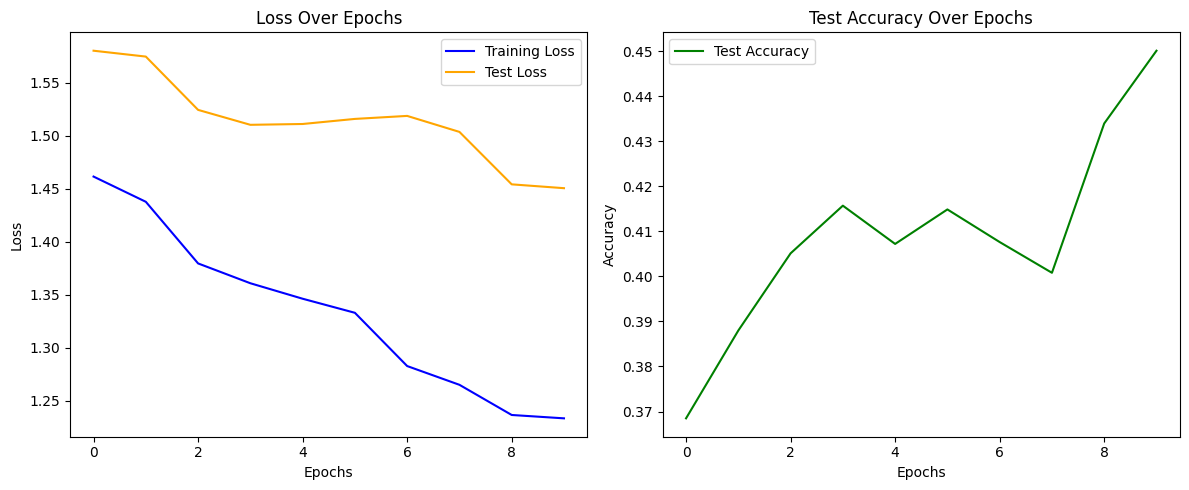

In [16]:
loaded_df4 = pd.read_csv("DE_CNN2_training_metrics.csv")
train_loss4 = loaded_df4["train_loss"].tolist()
test_loss4 = loaded_df4["test_loss"].tolist()
test_accuracy4 = loaded_df4["test_accuracy"].tolist()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss4, label='Training Loss', color='blue')
plt.plot(test_loss4, label='Test Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracy4, label='Test Accuracy', color='green')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(all_targets, all_preds)

np.savetxt(f'confusion_matrix.csv', conf_matrix, delimiter=',', fmt='%d')


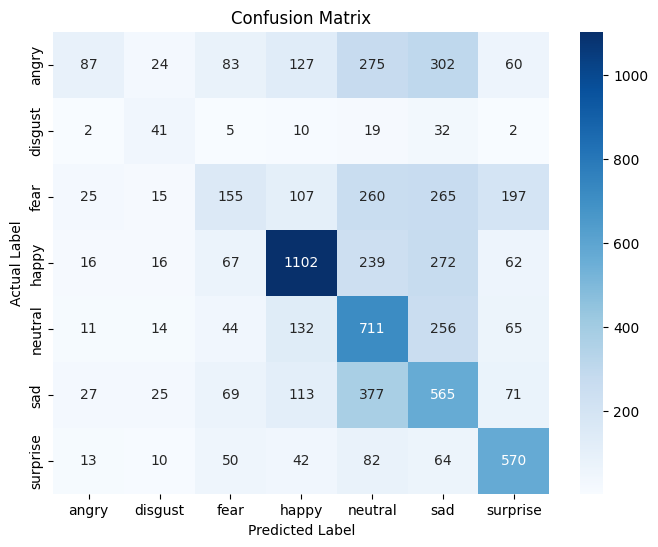

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset2.classes, yticklabels=train_dataset2.classes)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()